# Deep learning - convolution neural net

A simple demonstration of deep learning using a convolutional neural net (CNN) to classify images.

For most practical applications we would ideally use a pre-trained CNN with a proven good performance and just do some fine tuning for our specific task. However, I'm going to build a simple CNN from scratch for learning purposes.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import numpy as np
import math
import matplotlib.pyplot as plt

print('Tensorflow', tf.__version__)

Tensorflow 2.1.0


## Load data
We're going to use the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, citation:

> Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747

In [2]:
data = fashion_mnist
(x_train, y_train), (x_test, y_test) = data.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


We have 60,000 train examples and 10,000 test examples, each a 28x28 image.

Class labels (`y_*`) are
```
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
```

In [3]:
labels_dict = {0:'T-shirt/top',
               1:'Trouser',
               2:'Pullover',
               3:'Dress',
               4:'Coat',
               5:'Sandal',
               6:'Shirt',
               7:'Sneaker',
               8:'Bag',
               9:'Ankle boot'}

## Display some data

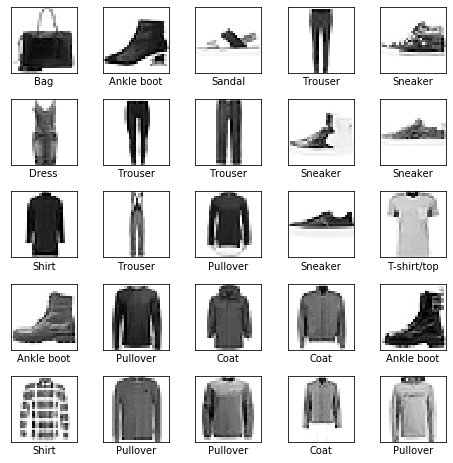

In [4]:
# Display some random, labelled images
n_train = x_train.shape[0] # number of training examples
n_images = 25 # number of images to display
display_rows = math.floor(math.sqrt(n_images))
display_cols = math.ceil(n_images / display_rows)

# Select n_images random images
rand_sel = np.random.randint(low=0, high=n_train, size=n_images)

plt.figure(figsize=(8, 8))
for i in range(n_images):
    image = x_train[rand_sel[i]]
    plt.subplot(display_rows, display_cols, i+1)
    plt.imshow(image, cmap='Greys')
    plt.xlabel(labels_dict[y_train[rand_sel[i]]])
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(hspace=0.4)
plt.show()

## Process data

We need to normalise the pixel values.

In [5]:
max_val = np.max(x_train)
print(max_val)
x_train = x_train / max_val
x_test = x_test / max_val
print(np.max(x_train))

255
1.0


We also need to add a depth channel to the data. `keras.layers.Conv2D()` expects the depth of the image to be specified - e.g. for a 3-channel colour image of 28x28 pixels it expects input of the form (28x28x3), for a greyscale image it expects (28x28x1). Right now our images are of shape (28x28), so we need to add the extra (x1) on the end.

In [6]:
print(x_train.shape)
x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]
print(x_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


## Define neural net

In [7]:
image_shape = x_train.shape[1:] # (28, 28, 1)
n_classes = len(set(y_train)) # 10

# Use geometric mean of input and output layer sizes for 
# number of nodes in hidden, fully-connected layer
n_features = np.prod(x_train.shape[1:3]) # 28*28
hidden_layer_size = int(math.sqrt(n_features * n_classes))

In [8]:
model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), strides=(1, 1),
           padding='same', activation='relu', input_shape=image_shape),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1),
           padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=hidden_layer_size, activation='relu'),
    Dense(units=n_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 88)                138072    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                8

**Explanation of the model summary:**
* The first element in `Output Shape` is the batch size. We're not using batches, hence we get `None` (https://stackoverflow.com/a/47241264).


* `conv2d` has 16 filters, each 3x3x1 in size (last dimension, depth==1, is because our input is greyscale; if we were using colour images we'd need a 3x3x3 filter for the three colour channels). So we have a `16*3*3*1` parameters, plus one bias parameter for each filter, for a total of `16*3*3*1+16=160` parameters.


* `conv2d_1` has 32 filters, each 3x3x16 in size (last dimension, depth==16, is because our input is the output of the `max_pooling2d` layer, which has a depth of 16).  So we have a `32*3*3*16` parameters, plus one bias parameter for each filter, for a total of `32*3*3*16+32=4640` parameters (see [here](https://cs231n.github.io/convolutional-networks/) for a good explanation of CNN paramater calculation, and CNNs in general).


* For the dense layers, it's just `(input+1)*units`, e.g. `(1568+1)*88 = 138072`, `(88+1)*10 = 890`, where the `+1` is for the bias.

In [9]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

## Train

In [10]:
history = model.fit(x_train, y_train, epochs=10, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 30s 501us/sample - loss: 0.4385 - accuracy: 0.8429 - val_loss: 0.3324 - val_accuracy: 0.8813
Epoch 2/10
60000/60000 [==============================] - 31s 517us/sample - loss: 0.2958 - accuracy: 0.8922 - val_loss: 0.2905 - val_accuracy: 0.8956
Epoch 3/10
60000/60000 [==============================] - 33s 546us/sample - loss: 0.2515 - accuracy: 0.9075 - val_loss: 0.2785 - val_accuracy: 0.8990
Epoch 4/10
60000/60000 [==============================] - 31s 522us/sample - loss: 0.2232 - accuracy: 0.9175 - val_loss: 0.2713 - val_accuracy: 0.9005
Epoch 5/10
60000/60000 [==============================] - 33s 550us/sample - loss: 0.2016 - accuracy: 0.9258 - val_loss: 0.2553 - val_accuracy: 0.9081
Epoch 6/10
60000/60000 [==============================] - 31s 513us/sample - loss: 0.1813 - accuracy: 0.9329 - val_loss: 0.2563 - val_accuracy: 0.9095
Epoch 7/10
60000/60000 [====================

## Visualise performance

In [11]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

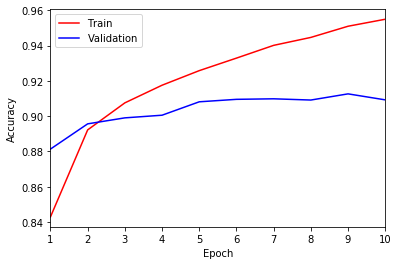

In [12]:
# Create array of epoch numbers for x-axis
n_epochs = len(train_acc)
epochs = np.arange(start=1, stop=n_epochs+1)

# Plot performance
plt.plot(epochs, train_acc, 'r-', label='Train')
plt.plot(epochs, val_acc, 'b-', label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(epochs[0], epochs[-1])
plt.xticks(epochs)
plt.show()

## Possible improvements

* Train-validate-test split. Right now the test set is also playing the part of the validation set. Since this is just an exmaple, and since we're not optimising anything based on the validation results, this is okay. However, if we wanted to, for example, optimise some hyperparameters or implement early stopping, we would need to do this based on a validation set that is independent of the test set.


* Optimise hyperaramters (NN architecure, number of epochs, activation function, etc). Depending on how thorough we wanted to be, we could do an extensive search over hyperparameter space using a grid search.


* Regularisation. We can see from the learning curves that the model is overiftting the data. We could combat this bye implementing regularisation, e.g. dropout and/or a weight constraint.


* Data augmentation. Another way to improve generalisability would be to increase the dataset size, either by collecting additional data (difficult) or using augmentation on our existing data (easy).


* Early stopping is another way to prevent overiftting - we can see from the learning curves that our validation performance stagnates beyond approximately 5 epochs of training.


* Transfer learning. As discussed at the top of the notebook, building a CNN from scratch is rarely a practical idea except for learning purposes (like here) or research. For most practical applications, we would use a pre-trained CNN with a proven good performance and just do some fine-tuning for our specific application. This should lead to improved performance.